In [1]:
from init import * 
from utils import (
    device,
    cuda,
    calculate_mean_std_mnist,
    show__random_img,
    config
)
from model import Net
from transforms import (
    train_transforms,
    test_transforms,
    custom_augmentation,
    MNISTDataset
)

In [2]:
torch.cuda.empty_cache()

In [3]:
torch.amp.autocast('cuda',enabled=False)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [4]:
mnist_data = datasets.MNIST( root=config['data']['dir_path'], download=False, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)
print(mean,std)

0.13066038489341736 0.3015033006668091


In [5]:
train_data = datasets.MNIST(config['data']['dir_path'], train=True,  download=False, transform=train_transforms)
test_data  = datasets.MNIST(config['data']['dir_path'], train=False, download=False, transform=test_transforms)

In [6]:
if cuda:
    kwargs = {
        'batch_size':config['batch_size'],
        'shuffle': config['shuffle'],
        'num_workers':config['num_workers'],
        'pin_memory':config['pin_memory']
    }
else:
    kwargs = {'batch_size':32,'shuffle':True}

train_loader = DataLoader(train_data,**kwargs)
test_loader  = DataLoader(test_data, **kwargs)

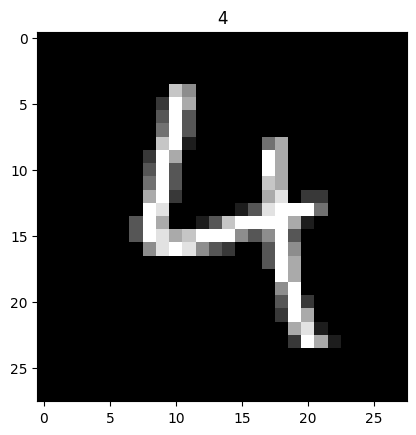

In [7]:
show__random_img()

In [8]:
# Data to plot accuracy and loss graphs (INIT)
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)
    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))
  return train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [9]:
model = Net().to(device)

In [10]:
for name,weights in model.named_parameters():
    print(f"{name}\t\t {weights.shape}")

conv1.0.weight		 torch.Size([8, 1, 3, 3])
conv1.2.weight		 torch.Size([8])
conv1.2.bias		 torch.Size([8])
conv1.4.weight		 torch.Size([10, 8, 3, 3])
conv1.6.weight		 torch.Size([10])
conv1.6.bias		 torch.Size([10])
conv1.8.weight		 torch.Size([10, 10, 3, 3])
conv1.10.weight		 torch.Size([10])
conv1.10.bias		 torch.Size([10])
trans1.1.weight		 torch.Size([8, 10, 1, 1])
conv2.0.weight		 torch.Size([10, 8, 3, 3])
conv2.1.weight		 torch.Size([10])
conv2.1.bias		 torch.Size([10])
conv2.4.weight		 torch.Size([12, 10, 3, 3])
conv2.5.weight		 torch.Size([12])
conv2.5.bias		 torch.Size([12])
conv2.8.weight		 torch.Size([12, 12, 3, 3])
conv2.9.weight		 torch.Size([12])
conv2.9.bias		 torch.Size([12])
trans2.1.weight		 torch.Size([8, 12, 1, 1])
trans2.2.weight		 torch.Size([8])
trans2.2.bias		 torch.Size([8])
conv3.0.weight		 torch.Size([10, 8, 3, 3])
conv3.1.weight		 torch.Size([10])
conv3.1.bias		 torch.Size([10])
conv3.4.weight		 torch.Size([12, 10, 3, 3])
conv3.6.weight		 torch.Size([12])
con

In [11]:
summary(model=model,input_size=(1,1,28,28),device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            72
│    └─ReLU: 2-2                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 28, 28]            16
│    └─Dropout2d: 2-4                    [1, 8, 28, 28]            --
│    └─Conv2d: 2-5                       [1, 10, 28, 28]           720
│    └─ReLU: 2-6                         [1, 10, 28, 28]           --
│    └─BatchNorm2d: 2-7                  [1, 10, 28, 28]           20
│    └─Dropout2d: 2-8                    [1, 10, 28, 28]           --
│    └─Conv2d: 2-9                       [1, 10, 28, 28]           900
│    └─ReLU: 2-10                        [1, 10, 28, 28]           --
│    └─BatchNorm2d: 2-11                 [1, 10, 28, 28]           20
│    └─Dropou

In [12]:

optimizer = optim.SGD(model.parameters(), lr=config['optimizer']['lr'], momentum=config['optimizer']['momentum'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1,patience=2,verbose=True) # step_size=config['scheduler']['step_size'], gamma=config['scheduler']['gamma'], 

criterion =  F.nll_loss
num_epochs = config['training']['num_epochs']

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_loss = train(model, device, train_loader, optimizer, criterion)
  test_loss  = test(model, device, test_loader, criterion)
  scheduler.step(train_loss)

/home/muthu/miniconda3/envs/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1


Train: Loss=0.0892 Batch_id=468 Accuracy=87.72: 100%|██████████| 469/469 [00:03<00:00, 131.53it/s]


Test set: Average loss: 0.0640, Accuracy: 9800/10000 (98.0000%)

Epoch 2


Train: Loss=0.0713 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:03<00:00, 133.16it/s]


Test set: Average loss: 0.0378, Accuracy: 9872/10000 (98.7200%)

Epoch 3


Train: Loss=0.0568 Batch_id=468 Accuracy=96.63: 100%|██████████| 469/469 [00:03<00:00, 130.39it/s]


Test set: Average loss: 0.0412, Accuracy: 9877/10000 (98.7700%)

Epoch 4


Train: Loss=0.0876 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:03<00:00, 132.92it/s]


Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.0600%)

Epoch 5


Train: Loss=0.0584 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:03<00:00, 133.11it/s]


Test set: Average loss: 0.0282, Accuracy: 9915/10000 (99.1500%)

Epoch 6


Train: Loss=0.1130 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:03<00:00, 134.37it/s]


Test set: Average loss: 0.0393, Accuracy: 9877/10000 (98.7700%)

Epoch 7


Train: Loss=0.0801 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:03<00:00, 135.68it/s]


Test set: Average loss: 0.0299, Accuracy: 9897/10000 (98.9700%)

Epoch 8


Train: Loss=0.0467 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:03<00:00, 134.75it/s]


Test set: Average loss: 0.0264, Accuracy: 9915/10000 (99.1500%)

Epoch 9


Train: Loss=0.0673 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:03<00:00, 129.79it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.2100%)

Epoch 10


Train: Loss=0.1249 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:03<00:00, 133.67it/s]


Test set: Average loss: 0.0256, Accuracy: 9916/10000 (99.1600%)

Epoch 11


Train: Loss=0.0388 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:03<00:00, 130.29it/s]


Test set: Average loss: 0.0271, Accuracy: 9906/10000 (99.0600%)

Epoch 12


Train: Loss=0.1334 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:03<00:00, 131.58it/s]


Test set: Average loss: 0.0224, Accuracy: 9922/10000 (99.2200%)

Epoch 13


Train: Loss=0.0732 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:03<00:00, 128.48it/s]


Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99.0100%)

Epoch 14


Train: Loss=0.0203 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:03<00:00, 133.61it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.2800%)

Epoch 15


Train: Loss=0.0353 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:03<00:00, 131.85it/s]


Test set: Average loss: 0.0213, Accuracy: 9928/10000 (99.2800%)



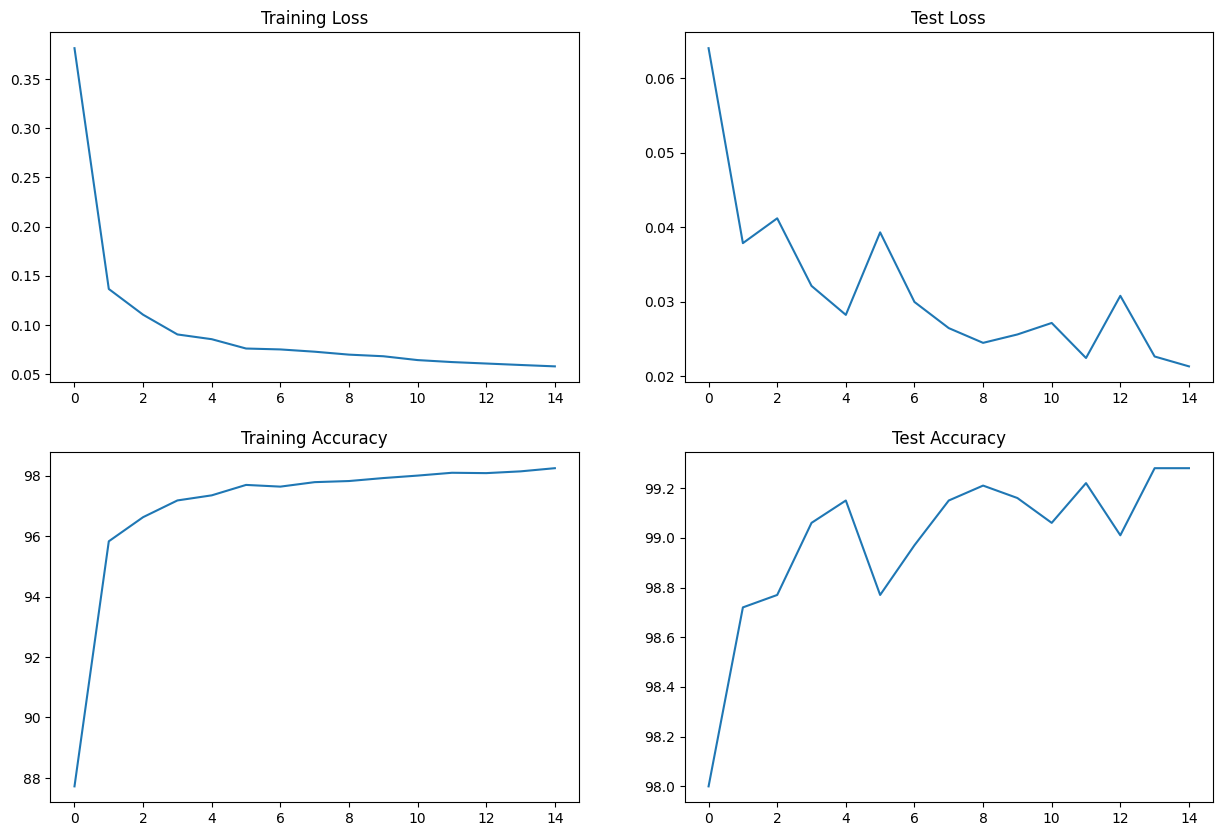

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

torch.Size([128, 1, 28, 28]) torch.Size([128])


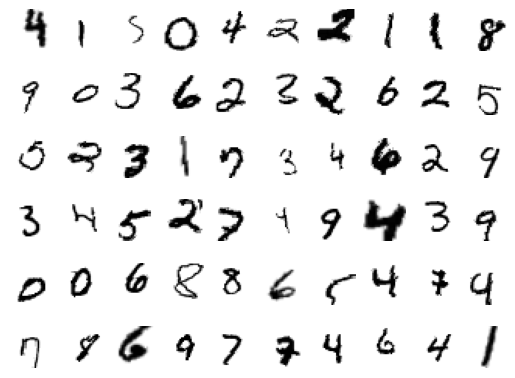

In [14]:
fig = plt.figure()

num_of_imgs=60

dataiter = iter(train_loader)
imgs,labels = next(dataiter)

print(imgs.shape,labels.shape)

for idx in range(1,num_of_imgs+1):
    plt.subplot(6,10,idx)
    plt.axis('off')
    plt.imshow(imgs[idx].numpy().squeeze(),cmap='binary')
plt.show()
